## **TJ Research Conference Project Code**

#### By: Dhruv Chandna, Vatsal Sivaratri

##### Below is our code for our project: "VesselVision: A Novel Approach to the Segmentation of Infrared Retinal Imaging." We presented this project at the 2023 TJ Student Reserach Conference hosted by the TJ Machine Learning Club.


##### The code contains preprocessing steps, experimentation of various model architectures, and finetuning.


### Step 1: Preprocessing the Data

In [2]:
#Imports necessary for the project

import pandas as pd
import numpy as np
from PIL import Image
import os
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow.keras import layers

In [3]:
def load_data(path):
    images = sorted(glob(os.path.join(path, "training_images/*")))
    masks = sorted(glob(os.path.join(path, "training_masks/*")))

    return images, masks

In [4]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [5]:
def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.float32)
    return x

In [6]:
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)
        
        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([256, 256, 3])
    masks.set_shape([256, 256, 1])

    return images, masks

In [7]:
def tf_dataset(x, y, batch=1):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [8]:
PATH = "/kaggle/input/ravir-segmentation/RAVIR Dataset/train"
images, masks = load_data(PATH)

In [11]:
BATCH = 1
dataset = tf_dataset(images, masks, batch=BATCH)

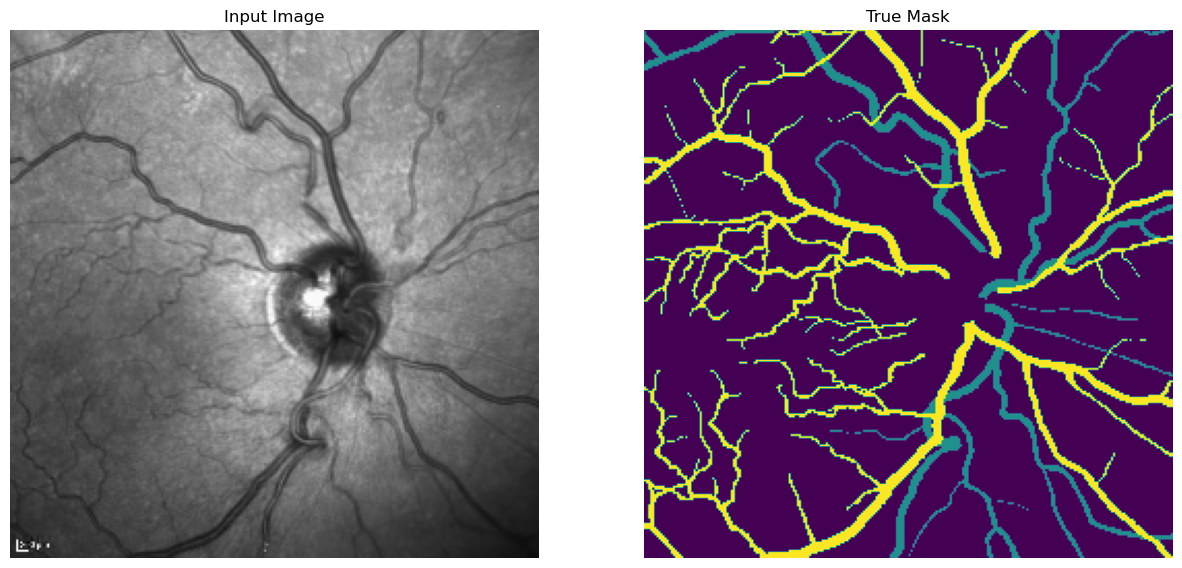

In [15]:
def display_images(display_list):
	plt.figure(figsize=(15, 15))
	title = ['Input Image', 'True Mask',
			'Predicted Mask']

	for i in range(len(display_list)):
		plt.subplot(1, len(display_list), i+1)
		plt.title(title[i])
#         print(display_list[i].shape)
		plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
		plt.axis('off')

	plt.show()


for img, mask in dataset.take(1):
    sample_image, sample_mask = img[0], mask[0]
    display_list = sample_image, sample_mask
    #print(np.unique(mask[0].numpy())))
    
display_images(display_list)


In [16]:
width = 256
height = 256

VGG16 Transfer Learning Model Working as an Encoder in the UNet Architecture. Contains 5 pooling layers that downsample the original image while learning a good representation of the data, working as a feature extractor

In [17]:
base_model = tf.keras.applications.vgg16.VGG16(
	include_top=False, input_shape=(width, height, 3))

layer_names = [
	'block1_pool',
	'block2_pool',
	'block3_pool',
	'block4_pool',
	'block5_pool',
]
base_model_outputs = [base_model.get_layer(
	name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input,
							base_model_outputs)

58889256/58889256 [==============================] - 0s 0us/step


In [18]:
def fcn8_decoder(convs, n_classes):
	f1, f2, f3, f4, p5 = convs

	n = 4096
	c6 = tf.keras.layers.Conv2D(
		n, (7, 7), activation='relu', padding='same',
	name="conv6")(p5)
	c7 = tf.keras.layers.Conv2D(
		n, (1, 1), activation='relu', padding='same',
	name="conv7")(c6)

	f5 = c7

	# upsample the output of the encoder
	# then crop extra pixels that were introduced
	o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
		4, 4), strides=(2, 2), use_bias=False)(f5)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 4 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f4
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 4 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample the resulting tensor of the operation you just did
	o = (tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(4, 4), strides=(2, 2),
	use_bias=False))(o)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 3 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f3
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 3 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample up to the size of the original image
	o = tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(8, 8), strides=(8, 8),
	use_bias=False)(o)

	# append a softmax to get the class probabilities
	o = tf.keras.layers.Activation('softmax')(o)
	return o


In [19]:
def dice_coef_cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=3)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_cat_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_cat(y_true, y_pred)

In [20]:
def segmentation_model():

	inputs = tf.keras.layers.Input(shape=(width, height, 3))
	convs = VGG_16(inputs)
	outputs = fcn8_decoder(convs, 3)
	model = tf.keras.Model(inputs=inputs, outputs=outputs)

	return model


opt = tf.keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
			loss=dice_coef_cat_loss,
			metrics=['accuracy'])


In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 128, 128, 6  14714688    ['input_2[0][0]']                
                                4),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                                
                                 (None, 32, 32, 256                                         

1/1 [==============================] - 9s 9s/step


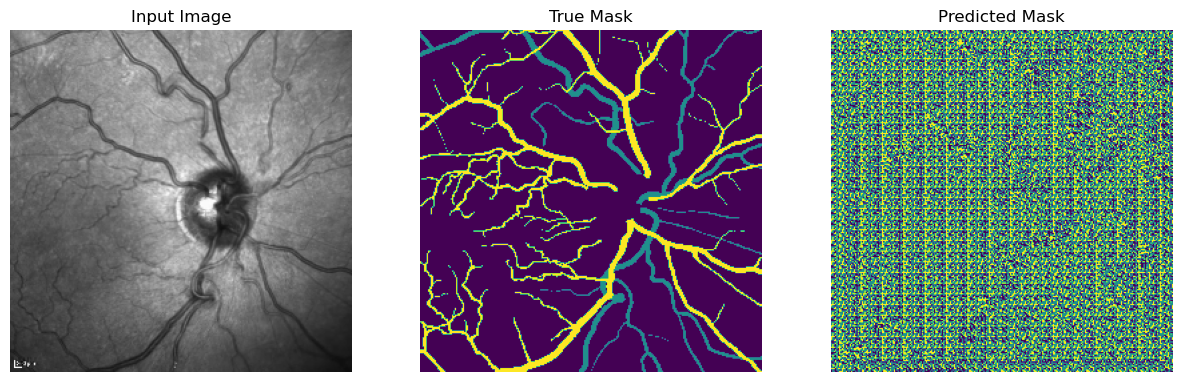

In [22]:
def create_mask(pred_mask):
	pred_mask = tf.argmax(pred_mask, axis=-1)
	pred_mask = pred_mask[..., tf.newaxis]
	return pred_mask[0]


def show_predictions(dataset=None, num=1):
	if dataset:
		for image, mask in dataset.take(num):
			pred_mask = model.predict(image)
			display_images([image[0], mask[0], create_mask(pred_mask)])
	else:
		display_images([sample_image, sample_mask,
						create_mask(model.predict(sample_image[tf.newaxis, ...]))])


show_predictions()


In [23]:
STEPS_PER_EPOCH = 23

EPOCHS = 50
model_history = model.fit(dataset, epochs=EPOCHS,
						steps_per_epoch=STEPS_PER_EPOCH)


Epoch 1/50
23/23 [==============================] - 8s 154ms/step - loss: 0.9094 - accuracy: 0.2652
Epoch 2/50
23/23 [==============================] - 4s 157ms/step - loss: 0.8752 - accuracy: 0.2620
Epoch 3/50
23/23 [==============================] - 4s 155ms/step - loss: 0.8623 - accuracy: 0.3024
Epoch 4/50
23/23 [==============================] - 4s 155ms/step - loss: 0.8526 - accuracy: 0.3739
Epoch 5/50
23/23 [==============================] - 4s 155ms/step - loss: 0.8450 - accuracy: 0.4195
Epoch 6/50
23/23 [==============================] - 4s 155ms/step - loss: 0.8355 - accuracy: 0.4793
Epoch 7/50
23/23 [==============================] - 4s 155ms/step - loss: 0.8209 - accuracy: 0.5364
Epoch 8/50
23/23 [==============================] - 4s 155ms/step - loss: 0.8126 - accuracy: 0.5613
Epoch 9/50
23/23 [==============================] - 4s 157ms/step - loss: 0.8061 - accuracy: 0.5745
Epoch 10/50
23/23 [==============================] - 4s 156ms/step - loss: 0.7991 - accuracy: 0.5923

In [25]:
hist_df = pd.DataFrame(model_history.history)
hist_df.to_csv(f"hist.csv")
model.save(f"model.h5")

In [26]:
def load_test(path):
    images = sorted(glob(os.path.join(path, "test/*")))
    return images

In [37]:
def make_ds(paths, width, height, channel=3):
    data = np.empty([0, width, height, channel])
    print(data.shape)
    for p in paths:
        x = cv2.imread(p, cv2.IMREAD_COLOR)
        x = cv2.resize(x, (width, height))
        x = x / 255.0
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)
#         print(data.shape)
#         print(x.shape)
        data = np.vstack((data, x))
    return data

In [38]:
PATH = "/kaggle/input/ravir-segmentation/RAVIR Dataset"
test_images = load_test(PATH)

test_ds = make_ds(test_images, width, height)

(0, 256, 256, 3)


1/1 [==============================] - 0s 26ms/step


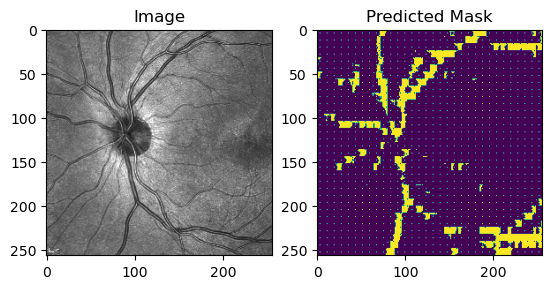

1/1 [==============================] - 0s 26ms/step


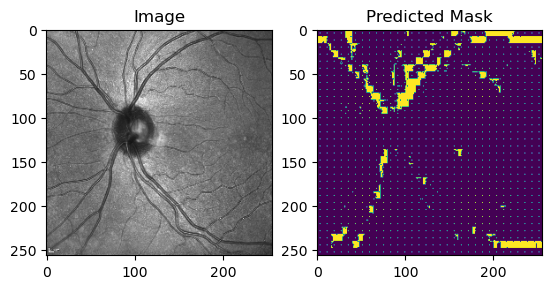

1/1 [==============================] - 0s 27ms/step


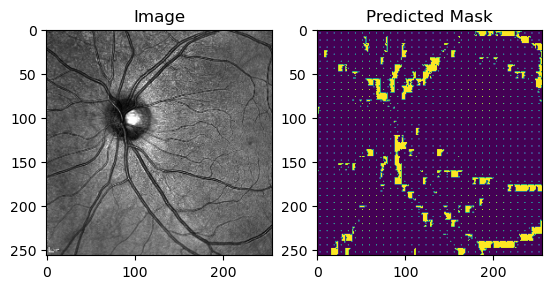

1/1 [==============================] - 0s 26ms/step


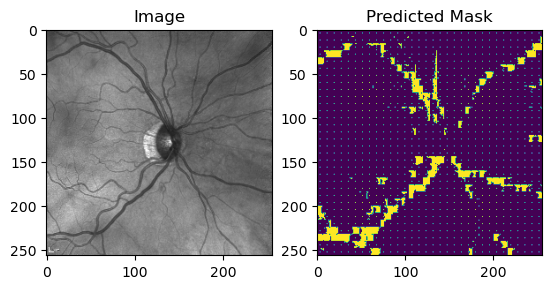

1/1 [==============================] - 0s 26ms/step


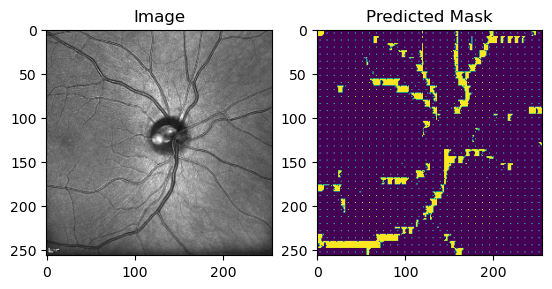

1/1 [==============================] - 0s 28ms/step


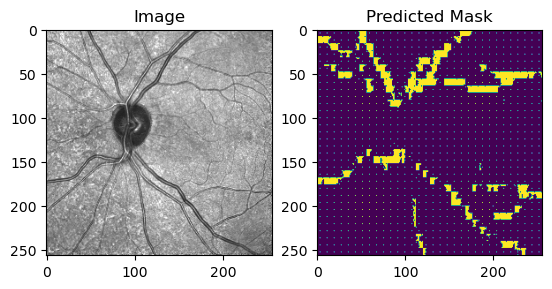

1/1 [==============================] - 0s 27ms/step


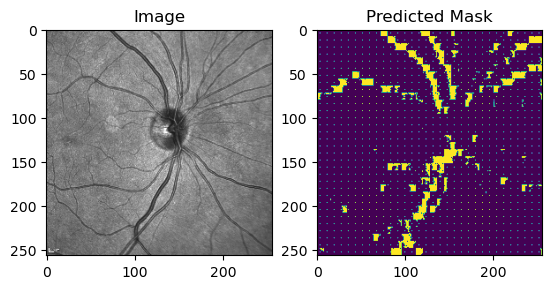

1/1 [==============================] - 0s 27ms/step


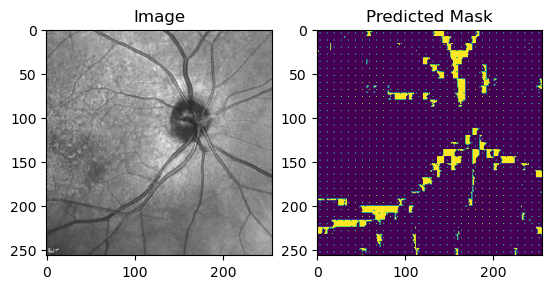

1/1 [==============================] - 0s 26ms/step


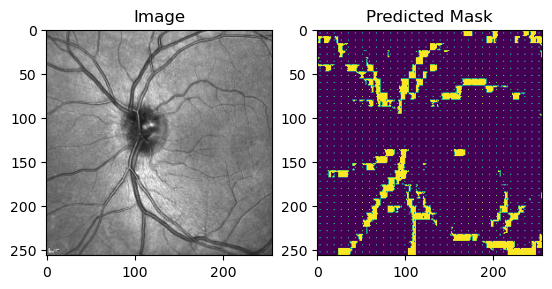

1/1 [==============================] - 0s 25ms/step


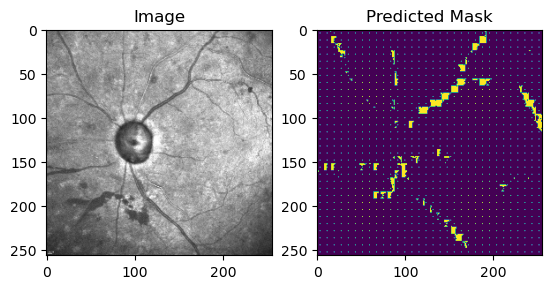

1/1 [==============================] - 0s 28ms/step


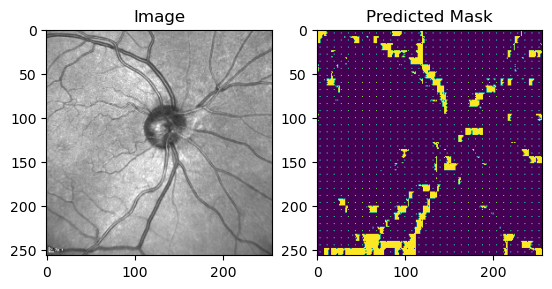

1/1 [==============================] - 0s 28ms/step


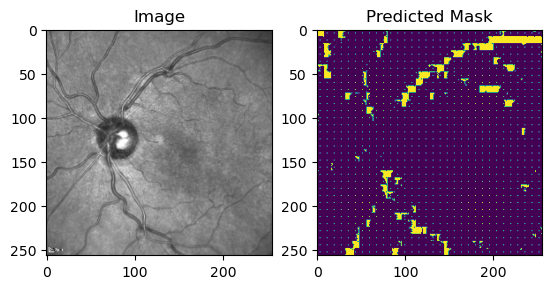

1/1 [==============================] - 0s 27ms/step


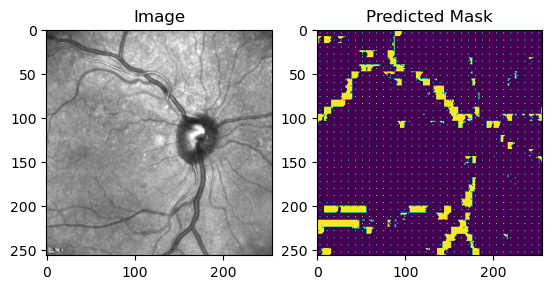

1/1 [==============================] - 0s 27ms/step


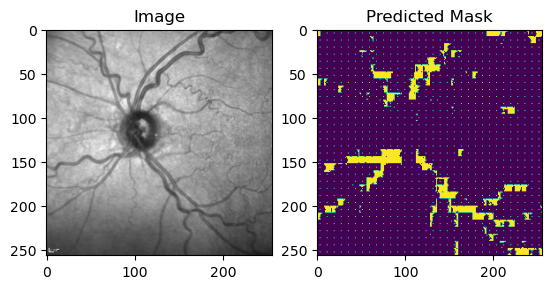

1/1 [==============================] - 0s 26ms/step


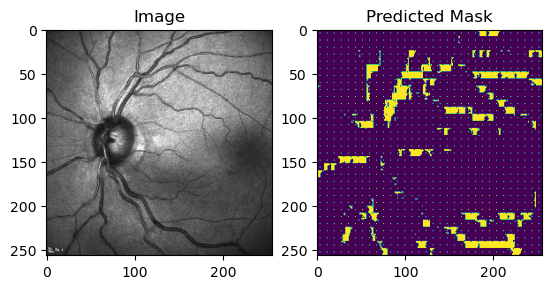

1/1 [==============================] - 0s 26ms/step


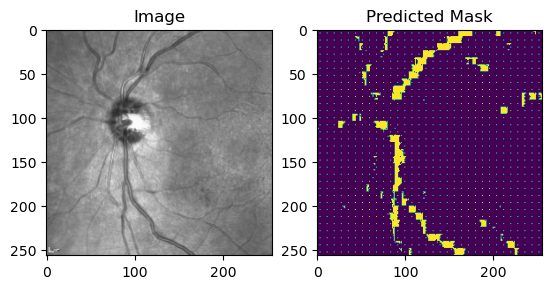

1/1 [==============================] - 0s 26ms/step


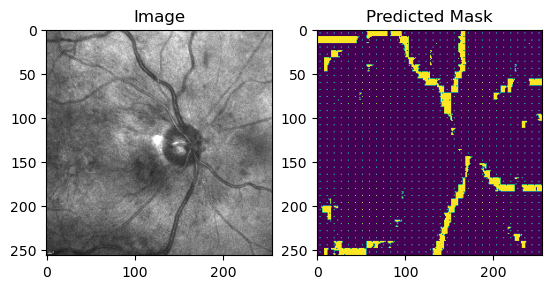

1/1 [==============================] - 0s 27ms/step


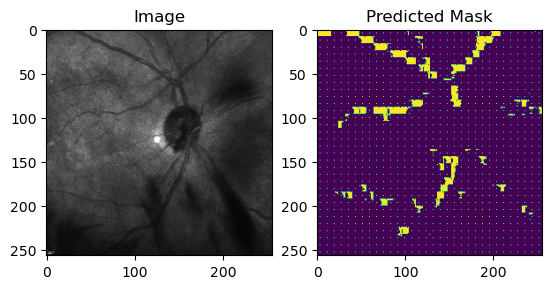

1/1 [==============================] - 0s 25ms/step


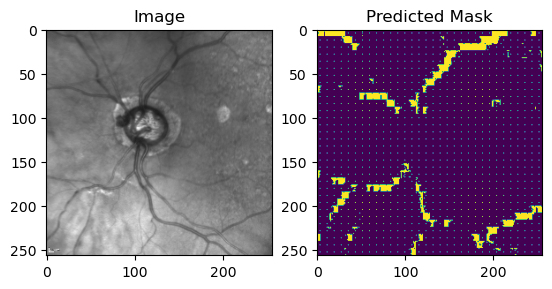

In [39]:
for im in test_ds:
    f, axarr = plt.subplots(1,2)
    im = np.expand_dims(im, axis=0)
    pred = model.predict(im)
    im = np.squeeze(im, axis=0)
    pred = np.argmax(pred, axis=-1)
    pred = np.squeeze(pred, axis=0)
    axarr[0].set_title("Image")
    axarr[0].imshow(im)
    axarr[1].set_title("Predicted Mask")
    axarr[1].imshow(pred)
    plt.show()